# Proyecto Redes Neuronales: Perceptrón Multicapa con PyTorch

**Curso:** Redes Neuronales 2025-II  
**Objetivo:** Entrenar y evaluar un modelo MLP usando PyTorch (Entrega 1 - refactorización)  
**Autor:** Herney Eduardo Quintero Trochez  
**Fecha:** 2025  
**Universidad:** Universidad Del Valle  

## 0. Configuración de Parámetros Globales

In [1]:
# ===== CONFIGURACIÓN DE PARÁMETROS GLOBALES =====

# Configuración general del experimento
EXPERIMENT_NAME = "MLP_PyTorch_BoW"
MODEL_TYPE = "MLP_BoW_Torch"
RANDOM_SEED = 42
PROJECT_PART = "project_part_1"

# Directorios de trabajo
DATA_DIR = "data"
MODEL_DIR = f"models/{PROJECT_PART}"
OUTPUT_DIR = f"output/{PROJECT_PART}"

# Configuración del dataset
TEXT_COLUMN = "review_body"
TITLE_COLUMN = "review_title"
TARGET_COLUMN = "stars"
LANGUAGE_COLUMN = "language"
FILTER_LANGUAGE = "en"  # None para todos
USE_TITLE_AND_BODY = True

# Parámetros de preprocesamiento BoW/TF-IDF
MAX_FEATURES = 5000
MIN_DF = 3
MAX_DF = 0.85

# Arquitectura del modelo
HIDDEN_LAYERS = [256, 128, 64]
DROPOUT_RATE = 0.3

# Parámetros de entrenamiento
EPOCHS = 50
BATCH_SIZE = 512
LEARNING_RATE = 0.001
PATIENCE = 10

print(f"=== Configuración: {EXPERIMENT_NAME} ===")
print(f"Framework: PyTorch")
print(f"Proyecto: {PROJECT_PART}")
print(f"Idioma: {FILTER_LANGUAGE if FILTER_LANGUAGE else 'Multiidioma'}")
print(f"Arquitectura: {HIDDEN_LAYERS}")
print("="*60)

=== Configuración: MLP_PyTorch_BoW ===
Framework: PyTorch
Proyecto: project_part_1
Idioma: en
Arquitectura: [256, 128, 64]


## 1. Importación de Librerías

In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from datetime import datetime
from sklearn.metrics import classification_report

# Importar helpers directamente desde sus módulos
from helpers.data_loader_torch import DataLoaderTorch
from helpers.model_trainer_torch import ModelTrainerTorch
from helpers.results_manager import ResultsManager
from helpers.visualizer import Visualizer
from helpers.models import MLPClassifier
from helpers.utils import (
    setup_experiment_environment_torch,
    save_model_components_torch,
    evaluate_model_torch
)

# Configurar ambiente
gpu_info = setup_experiment_environment_torch(RANDOM_SEED)
print(f"GPU disponible: {gpu_info['gpu_available']}")
if gpu_info['gpu_available']:
    print(f"GPU: {gpu_info['gpu_names']}")
    print(f"CUDA: {gpu_info['cuda_version']}")

GPU configurada: 1 GPU(s) disponibles
Usando: NVIDIA GeForce RTX 5070
GPU disponible: True
GPU: ['NVIDIA GeForce RTX 5070']
CUDA: 13.0


## 2. Carga y Preprocesamiento de Datos

In [3]:
# Cargar datos
data_loader = DataLoaderTorch(data_dir=DATA_DIR)
train_df, val_df, test_df = data_loader.load_all_data()

print(f"\nDatos originales:")
print(f"Train: {len(train_df):,}, Val: {len(val_df):,}, Test: {len(test_df):,}")

# Filtrar por idioma si se especifica
if FILTER_LANGUAGE and LANGUAGE_COLUMN in train_df.columns:
    print(f"\nFiltrando por idioma: {FILTER_LANGUAGE}")
    train_df = train_df[train_df[LANGUAGE_COLUMN] == FILTER_LANGUAGE].copy()
    val_df = val_df[val_df[LANGUAGE_COLUMN] == FILTER_LANGUAGE].copy()
    test_df = test_df[test_df[LANGUAGE_COLUMN] == FILTER_LANGUAGE].copy()
    print(f"Filtrados: Train: {len(train_df):,}, Val: {len(val_df):,}, Test: {len(test_df):,}")

# Distribución de clases
print(f"\nDistribución de clases:")
class_distribution = train_df[TARGET_COLUMN].value_counts().sort_index()
for stars, count in class_distribution.items():
    print(f"  {stars} estrellas: {count:,} ({count/len(train_df)*100:.1f}%)")

Datos cargados exitosamente: train.csv
Datos cargados exitosamente: validation.csv
Datos cargados exitosamente: test.csv

Datos originales:
Train: 1,200,000, Val: 30,000, Test: 30,000

Filtrando por idioma: en
Filtrados: Train: 200,000, Val: 5,000, Test: 5,000

Distribución de clases:
  1 estrellas: 40,000 (20.0%)
  2 estrellas: 40,000 (20.0%)
  3 estrellas: 40,000 (20.0%)
  4 estrellas: 40,000 (20.0%)
  5 estrellas: 40,000 (20.0%)


## 3. Preprocesamiento con PyTorch

In [4]:
# Preprocesar datos
print("\nPreprocesando con PyTorch...")
processed = data_loader.preprocess_text_data_bow(
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    text_column=TEXT_COLUMN,
    title_column=TITLE_COLUMN if USE_TITLE_AND_BODY else None,
    target_column=TARGET_COLUMN,
    max_features=MAX_FEATURES,
    min_df=MIN_DF,
    max_df=MAX_DF,
    use_title_and_body=USE_TITLE_AND_BODY,
    batch_size=BATCH_SIZE
)

# Extraer info
train_loader = processed['train_loader']
val_loader = processed['val_loader']
test_loader = processed['test_loader']
num_classes = processed['num_classes']
vocab_size = processed['vocab_size']

print(f"\nVocabulario: {vocab_size}")
print(f"Clases: {num_classes}")
print(f"Sparsity: {processed['sparsity']:.1%}")

class_names = [str(i) for i in data_loader.label_encoder.classes_]


Preprocesando con PyTorch...
Preprocesando datos con BoW para PyTorch...
Configuración: max_features=5000, min_df=3, max_df=0.85
Ajustando vocabulario...
Vocabulario: 5000 características
Número de clases: 5
Sparsity: 99.70%
Muestras - Train: 200000, Val: 5000, Test: 5000

Vocabulario: 5000
Clases: 5
Sparsity: 99.7%


## 4. Construcción del Modelo PyTorch

In [5]:
# Crear modelo
print("\nCreando modelo PyTorch...")
model = MLPClassifier(
    input_dim=vocab_size,
    hidden_layers=HIDDEN_LAYERS,
    num_classes=num_classes,
    dropout_rate=DROPOUT_RATE
)

total_params = sum(p.numel() for p in model.parameters())
print(f"Parámetros: {total_params:,}")
print(f"Arquitectura: {HIDDEN_LAYERS}")


Creando modelo PyTorch...
Parámetros: 2,602,314
Arquitectura: [256, 128, 64]


## 5. Configuración de Entrenamiento

In [6]:
# Definir criterio y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=PATIENCE//2
)

print("\nConfiguración:")
print(f"Optimizador: Adam (lr={LEARNING_RATE})")
print(f"Loss: CrossEntropyLoss")
print(f"Scheduler: ReduceLROnPlateau (factor=0.5, patience={PATIENCE//2})")


Configuración:
Optimizador: Adam (lr=0.001)
Loss: CrossEntropyLoss
Scheduler: ReduceLROnPlateau (factor=0.5, patience=5)


## 6. Entrenamiento

In [7]:
# Entrenar
trainer = ModelTrainerTorch(model_dir=MODEL_DIR)

print("\nIniciando entrenamiento...")
training_results = trainer.train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    epochs=EPOCHS,
    patience=PATIENCE,
    model_name=f"{MODEL_TYPE}_{datetime.now().strftime('%Y%m%d_%H%M%S')}",
    scheduler=scheduler
)

print(f"\nEntrenamiento completado:")
print(f"Épocas: {training_results['epochs_trained']}")
print(f"Tiempo: {training_results['training_time']:.1f}s")
print(f"Mejor Val Acc: {training_results['best_val_accuracy']:.4f}")

# Guardar componentes
model_name = os.path.basename(training_results['model_path']).replace('.pth', '')
save_model_components_torch(
    model_name=model_name,
    model=model,
    vectorizer=data_loader.vectorizer,
    label_encoder=data_loader.label_encoder,
    model_dir=MODEL_DIR
)

Usando dispositivo: cuda

Iniciando entrenamiento...

Entrenando MLP_BoW_Torch_20251130_135449...
Parámetros totales: 2,602,314
Parámetros entrenables: 2,602,314


Epoch 1/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 236.23it/s, loss=0.7273, acc=53.22%]



Epoch 1/50:
  Train Loss: 1.1645, Train Acc: 0.4882, Train F1-Macro: 0.4771
  Val Loss: 1.0727, Val Acc: 0.5322, Val F1-Macro: 0.5231
  Learning Rate: 0.001000
  ✓ Mejor modelo guardado (Val F1-Macro: 0.5231)


Epoch 2/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 229.32it/s, loss=0.7606, acc=53.36%]



Epoch 2/50:
  Train Loss: 1.0425, Train Acc: 0.5516, Train F1-Macro: 0.5461
  Val Loss: 1.0696, Val Acc: 0.5336, Val F1-Macro: 0.5269
  Learning Rate: 0.001000
  ✓ Mejor modelo guardado (Val F1-Macro: 0.5269)


Epoch 3/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 227.21it/s, loss=0.8575, acc=52.80%]



Epoch 3/50:
  Train Loss: 0.9955, Train Acc: 0.5762, Train F1-Macro: 0.5705
  Val Loss: 1.0746, Val Acc: 0.5280, Val F1-Macro: 0.5236
  Learning Rate: 0.001000
  Épocas sin mejora: 1/10


Epoch 4/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 221.86it/s, loss=0.7995, acc=52.40%]



Epoch 4/50:
  Train Loss: 0.9323, Train Acc: 0.6084, Train F1-Macro: 0.6033
  Val Loss: 1.1015, Val Acc: 0.5240, Val F1-Macro: 0.5185
  Learning Rate: 0.001000
  Épocas sin mejora: 2/10


Epoch 5/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 216.58it/s, loss=0.8985, acc=51.70%]



Epoch 5/50:
  Train Loss: 0.8497, Train Acc: 0.6478, Train F1-Macro: 0.6438
  Val Loss: 1.1479, Val Acc: 0.5170, Val F1-Macro: 0.5104
  Learning Rate: 0.001000
  Épocas sin mejora: 3/10


Epoch 6/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 228.16it/s, loss=0.9863, acc=51.18%]



Epoch 6/50:
  Train Loss: 0.7567, Train Acc: 0.6929, Train F1-Macro: 0.6898
  Val Loss: 1.2120, Val Acc: 0.5118, Val F1-Macro: 0.5120
  Learning Rate: 0.001000
  Épocas sin mejora: 4/10


Epoch 7/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 229.62it/s, loss=0.9279, acc=51.26%]



Epoch 7/50:
  Train Loss: 0.6727, Train Acc: 0.7314, Train F1-Macro: 0.7295
  Val Loss: 1.2874, Val Acc: 0.5126, Val F1-Macro: 0.5111
  Learning Rate: 0.001000
  Épocas sin mejora: 5/10


Epoch 8/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 221.10it/s, loss=1.0330, acc=51.24%]



Epoch 8/50:
  Train Loss: 0.6009, Train Acc: 0.7641, Train F1-Macro: 0.7627
  Val Loss: 1.3794, Val Acc: 0.5124, Val F1-Macro: 0.5093
  Learning Rate: 0.000500
  Épocas sin mejora: 6/10


Epoch 9/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 229.47it/s, loss=1.1929, acc=50.18%]



Epoch 9/50:
  Train Loss: 0.4923, Train Acc: 0.8117, Train F1-Macro: 0.8109
  Val Loss: 1.5470, Val Acc: 0.5018, Val F1-Macro: 0.5031
  Learning Rate: 0.000500
  Épocas sin mejora: 7/10


Epoch 10/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 223.61it/s, loss=1.2640, acc=50.52%]



Epoch 10/50:
  Train Loss: 0.4340, Train Acc: 0.8364, Train F1-Macro: 0.8359
  Val Loss: 1.6384, Val Acc: 0.5052, Val F1-Macro: 0.5065
  Learning Rate: 0.000500
  Épocas sin mejora: 8/10


Epoch 11/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 232.96it/s, loss=1.2847, acc=49.52%]



Epoch 11/50:
  Train Loss: 0.3953, Train Acc: 0.8526, Train F1-Macro: 0.8522
  Val Loss: 1.7177, Val Acc: 0.4952, Val F1-Macro: 0.4977
  Learning Rate: 0.000500
  Épocas sin mejora: 9/10


Epoch 12/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 238.56it/s, loss=1.4166, acc=50.08%]



Epoch 12/50:
  Train Loss: 0.3698, Train Acc: 0.8627, Train F1-Macro: 0.8624
  Val Loss: 1.7952, Val Acc: 0.5008, Val F1-Macro: 0.5028
  Learning Rate: 0.000500
  Épocas sin mejora: 10/10

Early stopping en época 12

Mejor modelo restaurado
Modelo guardado en: models/project_part_1/MLP_BoW_Torch_20251130_135449.pth

Entrenamiento completado:
Épocas: 12
Tiempo: 29.2s
Mejor Val Acc: 0.5336
Modelo guardado: models/project_part_1/MLP_BoW_Torch_20251130_135449.pth
  - Configuración guardada: {'input_dim': 5000, 'hidden_layers': [256, 128, 64], 'num_classes': 5}
Vectorizador guardado: models/project_part_1/MLP_BoW_Torch_20251130_135449_vectorizer.pkl
Label encoder guardado: models/project_part_1/MLP_BoW_Torch_20251130_135449_label_encoder.pkl
Componentes guardados en models/project_part_1/


## 7. Visualización

Gráfico de historial de entrenamiento guardado en: output/project_part_1/MLP_BoW_Torch_training.png


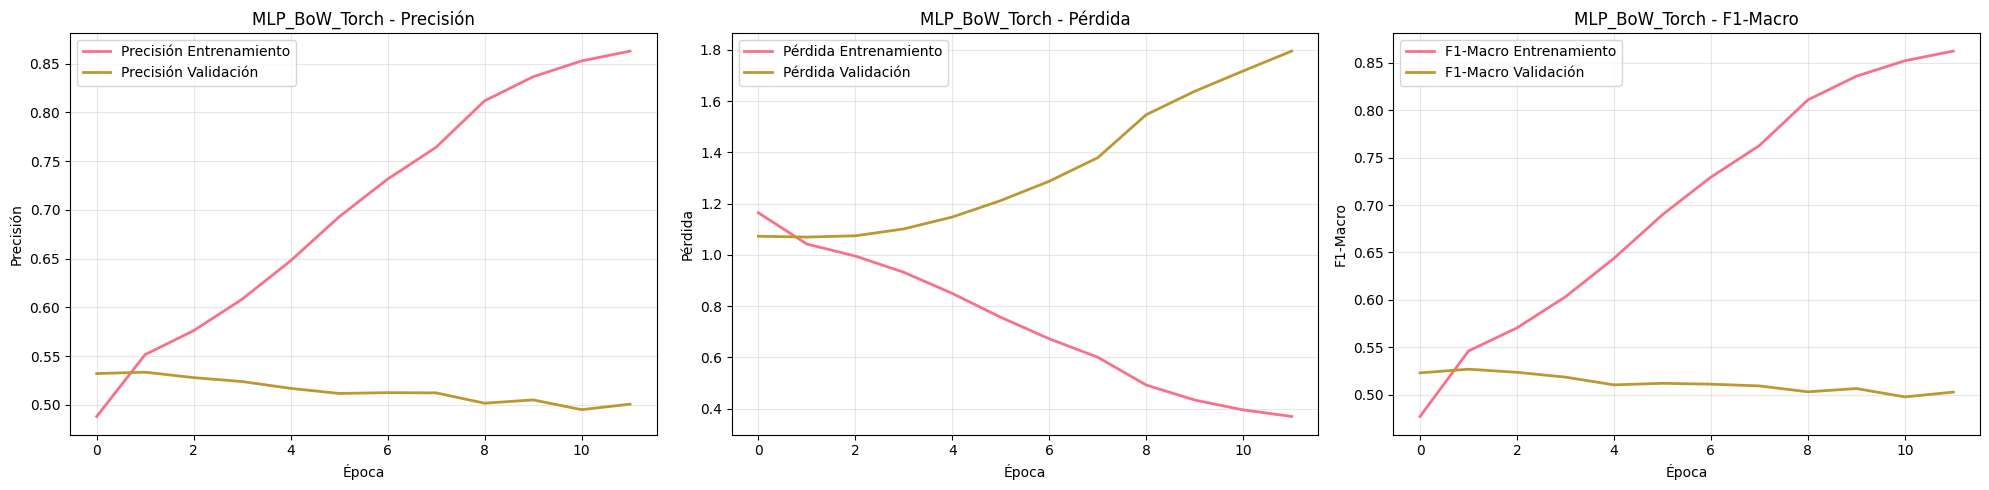

In [8]:
# Visualizar historial
Visualizer.plot_training_history(
    history=training_results['history'],
    model_name=MODEL_TYPE,
    save_path=os.path.join(OUTPUT_DIR, f"{MODEL_TYPE}_training.png"),
    framework="pytorch"
)

## 8. Evaluación

In [9]:
# Evaluar
eval_results = evaluate_model_torch(
    model=model,
    test_loader=test_loader,
    criterion=criterion,
    device=trainer.device,
    class_names=class_names
)

test_accuracy = eval_results['test_accuracy']
test_loss = eval_results['test_loss']
y_true = eval_results['y_true']
y_pred = eval_results['y_pred']

classification_rep = classification_report(y_true, y_pred, 
                                          target_names=class_names, 
                                          output_dict=True)

print(f"\nResultados:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Loss: {test_loss:.4f}")
print(f"F1 (macro): {classification_rep['macro avg']['f1-score']:.4f}")

Evaluando modelo en datos de prueba...
Precisión de Prueba: 0.5008
Pérdida de Prueba: 1.7711

Reporte de Clasificación:
              precision    recall  f1-score   support

           1       0.64      0.63      0.64      1000
           2       0.41      0.43      0.42      1000
           3       0.37      0.37      0.37      1000
           4       0.45      0.46      0.45      1000
           5       0.65      0.61      0.63      1000

    accuracy                           0.50      5000
   macro avg       0.50      0.50      0.50      5000
weighted avg       0.50      0.50      0.50      5000


Resultados:
Accuracy: 0.5008
Loss: 1.7711
F1 (macro): 0.5024


## 9. Matriz de Confusión

Matriz de confusión guardada en: output/project_part_1/MLP_BoW_Torch_confusion.png


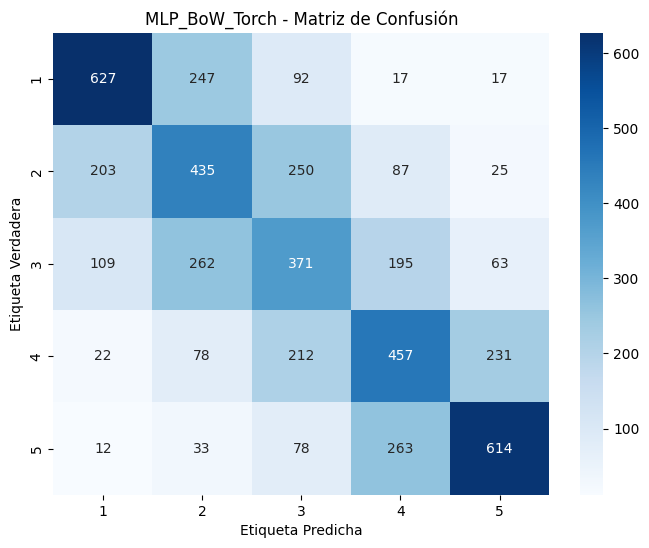

In [10]:
# Matriz de confusión
Visualizer.plot_confusion_matrix(
    y_true=y_true,
    y_pred=y_pred,
    class_names=class_names,
    model_name=MODEL_TYPE,
    save_path=os.path.join(OUTPUT_DIR, f"{MODEL_TYPE}_confusion.png")
)

## 10. Guardar Experimento

In [11]:
# Preparar datos del experimento
experiment_data = {
    'experiment_name': EXPERIMENT_NAME,
    'configuration': {
        'model_type': MODEL_TYPE,
        'framework': 'pytorch',
        'language_filter': FILTER_LANGUAGE,
        'max_features': MAX_FEATURES,
        'hidden_layers': HIDDEN_LAYERS,
        'dropout_rate': DROPOUT_RATE,
        'epochs': EPOCHS,
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'total_parameters': total_params,
        'gpu_used': gpu_info['gpu_available']
    },
    'dataset_info': {
        'train_samples': len(train_df),
        'val_samples': len(val_df),
        'test_samples': len(test_df),
        'num_classes': num_classes,
        'vocab_size': vocab_size,
        'class_distribution': class_distribution.to_dict()
    },
    'training_results': training_results,
    'evaluation_metrics': {
        'test_accuracy': test_accuracy,
        'test_loss': test_loss,
        'f1_macro': classification_rep['macro avg']['f1-score'],
        'f1_weighted': classification_rep['weighted avg']['f1-score'],
        'classification_report': classification_rep
    },
    'gpu_info': gpu_info
}

# Guardar
results_mgr = ResultsManager(output_dir="output", project_part=PROJECT_PART)
experiment_id = results_mgr.save_experiment_results(experiment_data)

print(f"\nExperimento #{experiment_id} guardado")
print(f"Proyecto: {PROJECT_PART}")
print(f"Modelo: {training_results['model_path']}")

Experiment 5 (MLP_PyTorch_BoW) saved to output/project_part_1/experiment_history.json

Experimento #5 guardado
Proyecto: project_part_1
Modelo: models/project_part_1/MLP_BoW_Torch_20251130_135449.pth
